Persiapan Data dan Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load Dataset
# Asumsi: Anda sudah upload file 'WA_Fn-UseC_-Telco-Customer-Churn.csv' ke Colab
# Jika belum, silakan upload di tab 'Files' sebelah kiri Colab
try:
    df = pd.read_csv('/content/drive/MyDrive/Dataset/dataset-UAS/WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Dataset berhasil dimuat!")
except:
    print("File tidak ditemukan. Pastikan Anda mengunggah file dataset Kaggle terlebih dahulu.")

Dataset berhasil dimuat!


Exploratory Data Analysis (EDA)

=== 5 Baris Pertama ===


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



=== Ringkasan Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


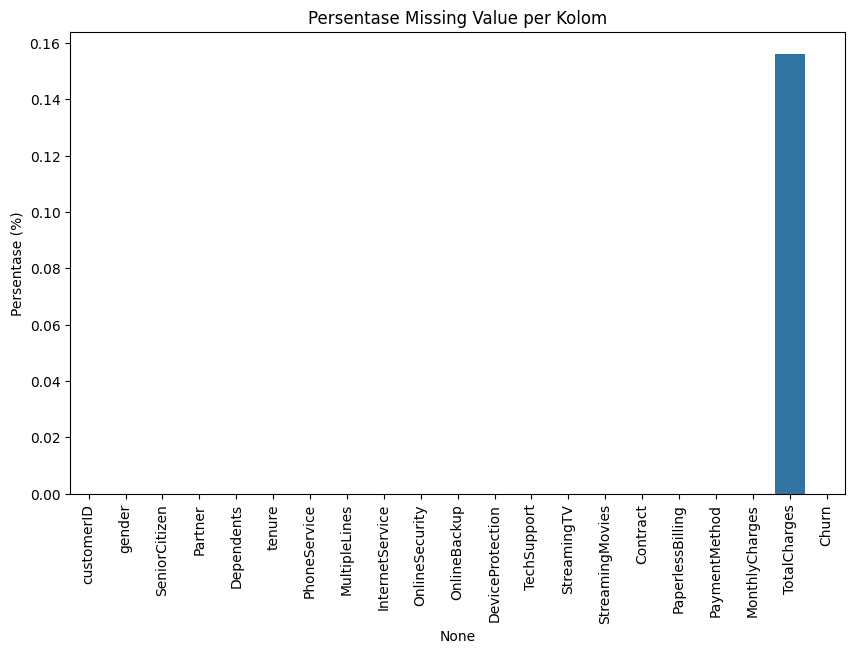

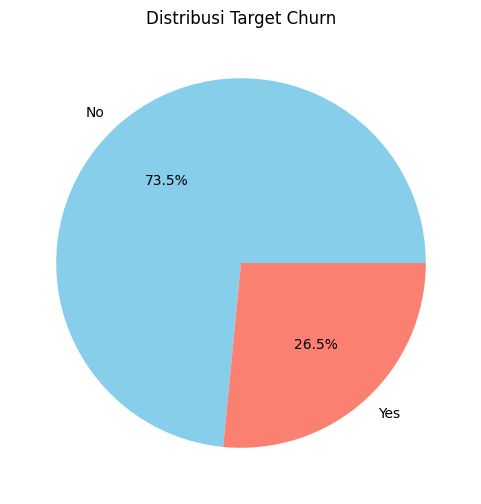

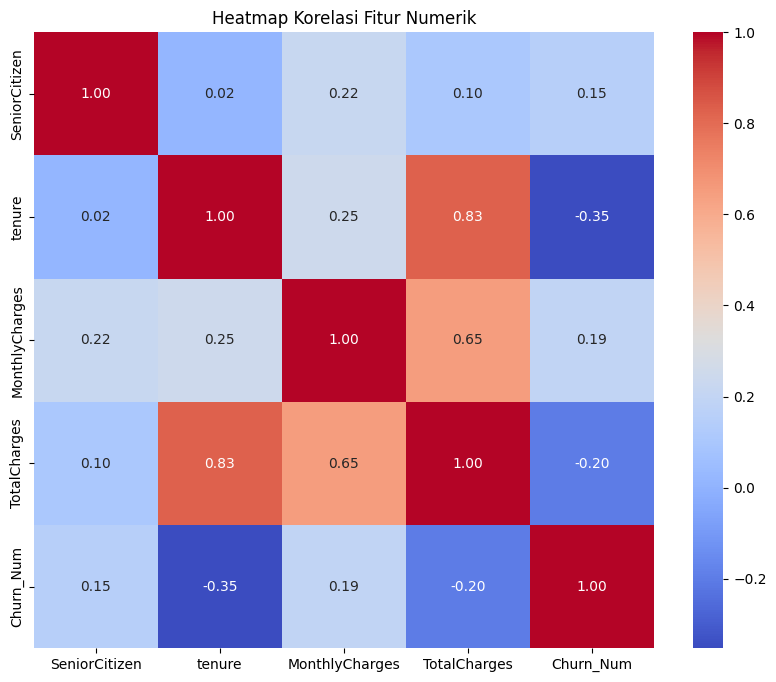

In [ ]:
# 1. Eksplorasi Awal
print("=== 5 Baris Pertama ===")
display(df.head())

print("\n=== Ringkasan Info ===")
print(df.info())

print("\n=== Statistik Deskriptif ===")
display(df.describe())

# 2. Identifikasi Missing Value
# Perlu diperhatikan: Kolom 'TotalCharges' seringkali terdeteksi object padahal harusnya float
# Kita paksa ubah ke numeric dulu, error jadi NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xticks(rotation=90)
plt.title("Persentase Missing Value per Kolom")
plt.ylabel("Persentase (%)")
plt.show()

# 3. Visualisasi Distribusi Target (Churn)
plt.figure(figsize=(6, 6))
df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title("Distribusi Target Churn")
plt.ylabel('')
plt.show()

# 4. Analisis Korelasi (Hanya Fitur Numerik)
# Kita perlu mengubah Churn Yes/No menjadi 1/0 agar bisa masuk korelasi
df['Churn_Num'] = df['Churn'].map({'Yes': 1, 'No': 0})
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap Korelasi Fitur Numerik")
plt.show()

Direct Modeling (Tanpa Preprocessing)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

# Opsi Tambahan: Bungkam warning khusus convergence agar output bersih (Opsional)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Siapkan Data untuk Direct Modeling
df_direct = df.copy()
df_direct.drop(['customerID', 'Churn_Num'], axis=1, inplace=True)

# Encoding sederhana
le = LabelEncoder()
for column in df_direct.columns:
    if df_direct[column].dtype == 'object':
        df_direct[column] = le.fit_transform(df_direct[column].astype(str))

df_direct.fillna(0, inplace=True)

# 2. Split Data
X_direct = df_direct.drop('Churn', axis=1)
y_direct = df_direct['Churn']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_direct, y_direct, test_size=0.2, random_state=42)

# 3. Definisi Model (DENGAN MAX_ITER LEBIH TINGGI)
# Kita naikkan max_iter ke 5000 agar solver punya cukup waktu untuk konvergen pada data mentah
model_logreg = LogisticRegression(max_iter=5000)
model_rf = RandomForestClassifier(random_state=42)
model_voting = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=5000)), # Update juga disini
    ('rf', model_rf),
    ('knn', KNeighborsClassifier())], voting='soft')

# 4. Train & Evaluasi
models = {'Logistic Regression': model_logreg, 'Random Forest': model_rf, 'Voting': model_voting}

print("=== Hasil Evaluasi Direct Modeling (Updated) ===")
for name, model in models.items():
    model.fit(X_train_d, y_train_d)
    y_pred = model.predict(X_test_d)

    print(f"\nModel: {name}")
    print(f"Accuracy: {accuracy_score(y_test_d, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test_d, y_pred):.4f}")

=== Hasil Evaluasi Direct Modeling (Updated) ===

Model: Logistic Regression
Accuracy: 0.8162
F1-Score: 0.6252

Model: Random Forest
Accuracy: 0.7949
F1-Score: 0.5491

Model: Voting
Accuracy: 0.8133
F1-Score: 0.5960


Modeling Dengan Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Reset Data
df_clean = df.drop(['customerID', 'Churn_Num'], axis=1)

# Pisahkan Fitur dan Target
X = df_clean.drop('Churn', axis=1)
y = df_clean['Churn'].map({'Yes': 1, 'No': 0}) # Target jadi numerik 1/0

# Identifikasi Kolom
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [c for c in X.columns if c not in num_cols]

# 2. Pipeline Preprocessing [cite: 65]
# Numerik: Imputasi Mean -> Scaling Standard
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Kategorikal: Imputasi Frequent -> OneHotEncoding
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

# 3. Train Test Split [cite: 72]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Melatih Kembali Model dengan Pipeline [cite: 73]
# Kita buat dictionary pipeline agar kode rapi
pipelines = {
    'Logistic Regression': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000))]),
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))]),
    'Voting': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('knn', KNeighborsClassifier())], voting='soft'))])
}

print("=== Hasil Evaluasi Dengan Preprocessing ===")
results = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1}
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.4f} | F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

=== Hasil Evaluasi Dengan Preprocessing ===

Model: Logistic Regression
Accuracy: 0.8211 | F1-Score: 0.6400
Confusion Matrix:
[[933 103]
 [149 224]]

Model: Random Forest
Accuracy: 0.7892 | F1-Score: 0.5395
Confusion Matrix:
[[938  98]
 [199 174]]

Model: Voting
Accuracy: 0.8041 | F1-Score: 0.5953
Confusion Matrix:
[[930 106]
 [170 203]]


Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Kita pilih Random Forest untuk dituning
rf_pipeline = pipelines['Random Forest']

# 1. Menyusun Parameter Grid [cite: 77]
# Kita tuning parameter pada langkah 'classifier' (RandomForest)
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5]
}

# 2. Proses Tuning
print("Sedang melakukan tuning... (ini mungkin memakan waktu)")
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 3. Hasil Terbaik [cite: 79]
print("\nParameter Terbaik:", grid_search.best_params_)
print("Skor Validasi Terbaik (F1):", grid_search.best_score_)

# 4. Evaluasi Model Terbaik [cite: 80, 87]
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\n=== Evaluasi Model Setelah Tuning ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tuned):.4f}")

Sedang melakukan tuning... (ini mungkin memakan waktu)

Parameter Terbaik: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Skor Validasi Terbaik (F1): 0.5748542831629045

=== Evaluasi Model Setelah Tuning ===
Accuracy: 0.8112
Precision: 0.6826
Recall: 0.5362
F1-Score: 0.6006


Deployment Preparation

In [ ]:
import joblib

# 1. Simpan Model Terbaik
joblib.dump(best_model, 'model_churn_terbaik.pkl')
print("Model berhasil disimpan sebagai 'model_churn_terbaik.pkl'")
print("Silakan download file ini dari panel Files di sebelah kiri.")

Model berhasil disimpan sebagai 'model_churn_terbaik.pkl'
Silakan download file ini dari panel Files di sebelah kiri.


In [ ]:
import sklearn
import joblib
import pandas

print(f"scikit-learn=={sklearn.__version__}")
print(f"joblib=={joblib.__version__}")
print(f"pandas=={pandas.__version__}")

scikit-learn==1.6.1
joblib==1.5.3
pandas==2.2.2
